# 畳み込みニューラルネットワーク(Convolutional Neural Network:CNN)

## 解説

例えば、画像を扱っている場合は、エッジやブロブといった低レベルの特徴量を最初の方の層から抽出する。そしてそれらの特徴量を組み合わせることで、高レベルの特徴量を形成する。    
一般に、CNNは複数の**畳み込み層**と**サブサンプリング層**（例：プーリング層：学習可能なパラメータは存在しない）で構成され、それに続いて最後に全結合層が1つ以上存在する。
### 局所受容野
* 疎結合
* パラメータの共有

### 出力マップのサイズを制御するための入力のパディング
- fullモード  
$p=m-1$で設定される。出力の次元が増えるため、CNNのアーキテクチャでは滅多に使われない。
- sameモード  
入力と出力のサイズが同じ、$p$はフィルタのサイズに基づいて計算される。CNNで最もよく使われる。
- validモード  
$p=0$（パディングなし）で実行されることを意味する。
#### 出力のサイズ

$$
o = \lfloor \frac{n+2p-m}{s} \rfloor+1

$$
$n:入力サイズ, m:フィルタサイズ, p:パディングサイズ, s:ストライド$

In [1]:
import numpy as np
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot)) / s) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same')) 

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


### ２次元の離散畳み込み
$$
Y = X * W \rightarrow Y[i, j] = \sum_{k_1 = -\infty}^{+\infty} \sum_{k_2 = -\infty}^{+\infty} X[i - k_1, j - k_2] W[k_1, k_2] 
$$

ここで：
- $ X[i - k_1, j - k_2] $：入力画像の画素値
- $ W[k_1, k_2] $：カーネル（フィルタ）の値
- $ Y[i, j] $：出力特徴マップの画素値

### なぜ畳み込みの形状なのか？
実際は「畳み込み」ではなく、普通に「相関」を使って形状検出をしている。NNにおいては、どちらでも同じ働きをする、  
畳み込みで説明される理由は、歴史的な経緯や信号処理からの影響が強いらしい。システムの応答（出力）を入力とたたみ込むことで求めるという考えに由来する（フーリエ変換）。

In [2]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


最近では、畳み込みの計算にフーリエ変換を利用する、はるかに効率のよいアルゴリズムが開発されている。

### サブサンプリング層

一般に、CNNの２種類のプーリング演算という形で適用される。これらのプーリング演算は、**最大値プーリング**と**平均値プーリング**である。  
プーリング（最大値プーリング）は、一種の局所不変性をもたらす。近傍が局所的に少し変化したとしても、最大値プーリングの結果は変化しない。よってより頑健な特徴量を生成するのに役立つ。通常、オーバーラップしていない近傍で実行されるがオーバーラップありのものも提案されている。

プーリング層あり、なし比較論文：  
Striving for Simplicity: The All Convolutional Net

## 実装

画像ファイルを操作するときは、'uint8'型（符号なし８ビット整数）のNumpy配列に画像を読み込むことで、メモリ消費を減らすことができる。

サンプル　　　：　$\mathbf{X}_{n_1 \times n_2 \times C_{\text{in}}}$  
カーネル行列　：　$\mathbf{W}_{m_1 \times m_2 \times C_{\text{in}}}$  
バイアス値　　：　$b$  

$$
Z_{\text{Conv}} = \sum_{c=1}^{C_{\text{in}}} \mathbf{W}[:, :, c] * \mathbf{X}[:, :, c]
$$

$$
Z = Z_{\text{Conv}} + b
$$

$$
\text{特徴マップ：} \quad \mathbf{A} = \sigma(Z)
$$


### 正則化とドロップアウト
#### ドロップアウト
訓練段階と予測段階とで全体的な活性化の尺度を揃えるには、有効なニューロンの活性化を適切な尺度にする必要がある。例えば、ドロップアウト確率がp=0.5に設定されている場合、活性化を半分にすることが考えられる。PyTorchなどのツールは訓練時に活性化の尺度を調整するようになっている。このアプローチは逆ドロップアウトと呼ばれる。  
アンサンブル的な効果？

### 損失関数
| 損失関数                          | 用途       | 例：確率を使用                           | 例：ロジットを使用                         |
|----------------------------------|------------|------------------------------------------|--------------------------------------------|
| NLLLoss または CrossEntropyLoss | 多クラス分類 | **NLLLoss**<br>Y_true: 2<br>Y_pred: [0.30, 0.15, 0.55] | **CrossEntropyLoss**<br>Y_true: 2<br>Y_pred: [1.5, 0.8, 2.1] |
| BCEWithLogitsLoss または BCELoss| 二値分類    | **BCELoss**<br>Y_true: 1<br>Y_pred: 0.69 | **BCEWithLogitsLoss**<br>Y_true: 1<br>Y_pred: 1.08 |


### ディープ畳み込みニューラルネットワーク(DNN)
1. 畳み込み層（Convolutional Layer）
2. プーリング層（Pooling Layer）
3. 平坦化（Flatten）
4. 全結合層（Fully Connected Layer / Dense Layer）
5. 出力層（Softmaxなど）

平坦化(flatten)：多次元の特徴マップを１次元のベクトルに変換する。

In [3]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([transforms.ToTensor()]) # [0, 255] -> [0.0, 1.0] に変換
mnist_dataset = torchvision.datasets.MNIST(image_path, train=True, download=True, transform=transform)

import torch
from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(image_path, train=False, download=False, transform=transform)

In [4]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size=batch_size, shuffle=False)

In [5]:
import torch.nn as nn
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [6]:
# Conv2Dクラスでは、入力がデフォルトでNCHW形式であることを想定している。
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [7]:
model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [8]:
model.add_module('fc1', nn.Linear(64*7*7, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))
model.add_module('softmax', nn.Softmax(dim=1))

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: '
              f'{accuracy_hist_train[epoch]:.4f} val accuracy: '
              f'{accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [11]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9257 val accuracy: 0.9704
Epoch 2 accuracy: 0.9724 val accuracy: 0.9789
Epoch 3 accuracy: 0.9789 val accuracy: 0.9835
Epoch 4 accuracy: 0.9818 val accuracy: 0.9798
Epoch 5 accuracy: 0.9828 val accuracy: 0.9830
Epoch 6 accuracy: 0.9841 val accuracy: 0.9847
Epoch 7 accuracy: 0.9848 val accuracy: 0.9856
Epoch 8 accuracy: 0.9857 val accuracy: 0.9846
Epoch 9 accuracy: 0.9874 val accuracy: 0.9826
Epoch 10 accuracy: 0.9857 val accuracy: 0.9868
Epoch 11 accuracy: 0.9869 val accuracy: 0.9861
Epoch 12 accuracy: 0.9868 val accuracy: 0.9847
Epoch 13 accuracy: 0.9874 val accuracy: 0.9854
Epoch 14 accuracy: 0.9880 val accuracy: 0.9864
Epoch 15 accuracy: 0.9884 val accuracy: 0.9846
Epoch 16 accuracy: 0.9879 val accuracy: 0.9861
Epoch 17 accuracy: 0.9877 val accuracy: 0.9859
Epoch 18 accuracy: 0.9869 val accuracy: 0.9843
Epoch 19 accuracy: 0.9874 val accuracy: 0.9836
Epoch 20 accuracy: 0.9889 val accuracy: 0.9838


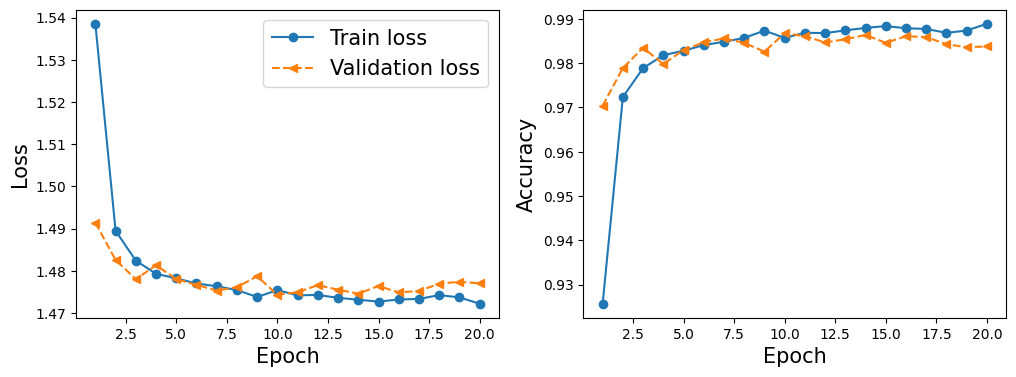

In [12]:
import matplotlib.pyplot as plt
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [13]:
pred = model(mnist_test_dataset.data.unsqueeze(1).float() / 255.0)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9897


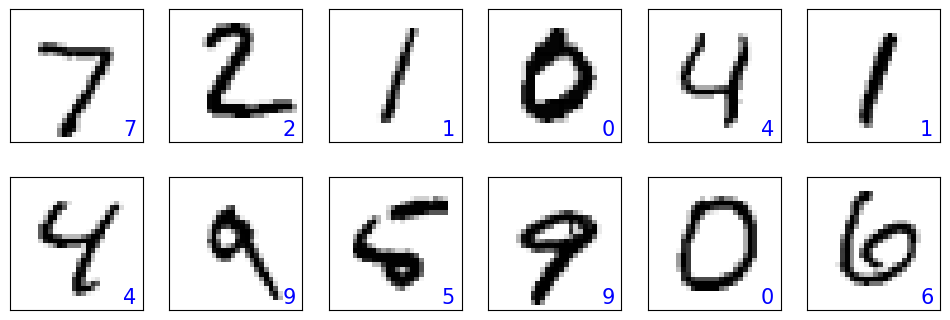

In [15]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), size=15, color='blue',
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes)
    
plt.show()